# Nonlinearity Analysis with NHANES Data

## Setup

In [1]:
import itertools
import loadnhanes
import sklearn
import numpy as np
import shap
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse, r2_score as r2, roc_auc_score as auc
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from scipy.special import expit, logit
from collections import defaultdict
import mpld3

In [2]:
%matplotlib inline

In [3]:
VAL_SEED = 27
TEST_SEED = 12

NP_SEED = 10
XG_SEED=20
np.random.seed(NP_SEED)

In [4]:
# Binary cross-entropy for scoring models
def bce(truth,preds):
    return np.mean(-truth*np.log(preds)-(1-truth)*np.log(1-preds))

In [5]:
import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as sm_glm

# Range of regularization strengths
ALPHAS = [0.0]

# # Uncomment to use a regularized model and do a parameter search
# ALPHAS = np.logspace(-10,4,15)

# StatsModels logistic regression
# family is statsmodels family to fit as link function
# score is metric to optimize; must be positive
class SmGlm(object):
    def __init__(self,family=sm.families.Binomial(),score=r2):
        self.family = family
        self.fit_results = []
        self.fit_scores = []
        self.best_ind = None
        self.score = score
        
    def fit(self, X, y):
        # Handle Pandas
        if str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            X = X.values
        # Append bias term
        X=np.hstack((X,np.ones(X.shape[0]).reshape(-1,1)))
        
        # Split for model tuning; all validation splits are the same throughout this code
        Xtt,Xtv,ytt,ytv = sklearn.model_selection.train_test_split(
            X, y, test_size=0.2, random_state=VAL_SEED)        
        
        # Tune regularizaton parameter
        for alpha in ALPHAS:
            # Instantiate GLM
            model_class = sm_glm.GLM(ytt,Xtt,family=self.family)
            
            model = model_class.fit_regularized(alpha=alpha)
            self.fit_results.append(model)
            preds = model.predict(Xtv)
            self.fit_scores.append(self.score(ytv,preds))
        self.best_ind = np.argmax(self.fit_scores)
        
    def predict(self, X):
        # Handle Pandas
        if str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            X = X.values
            
        # Append bias term
        X=np.hstack((X,np.ones(X.shape[0]).reshape(-1,1)))
        
        # Predict
        return self.fit_results[self.best_ind].predict(X)

In [6]:
# Load data
X = pd.read_csv("data/X_orig.csv",index_col=0)
y = np.load("data/y_orig.npy")

# Preprocess BMI
# Silly trick, each of the height values in denominator should be divided by 100 to get meters
# so instead we multiply result by 10,000
X["bmi"] = 10000 * X["weight"].values.copy() / (X["height"].values.copy() * X["height"].values.copy())
del X["weight"]
del X['height']
bottom, top = X.quantile(0.01),X.quantile(0.99)
X_orig = X
X = X.clip(lower=bottom,upper=top,axis=1)
# Winsorize
bottom, top = X.quantile(0.01),X.quantile(0.99)
X_orig = X
X = X.clip(lower=bottom,upper=top,axis=1)

# Train test split
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
        X, y, test_size=0.2, random_state=TEST_SEED)
Xtraintrain, Xtrainvalid, ytraintrain, ytrainvalid = sklearn.model_selection.train_test_split(
        Xtrain, ytrain, test_size=0.2, random_state=VAL_SEED)

In [ ]:
# Scale data
mu = Xtrain.mean()
sigma = Xtrain.var()**0.5

X -= mu
Xtrain -= mu
Xtraintrain -= mu
Xtrainvalid -= mu
Xtest -= mu
for col in sigma.index:
    if sigma[col] != 0:
        X[col] /= sigma[col]
        Xtrain[col] /= sigma[col]
        Xtraintrain[col] /= sigma[col]
        Xtrainvalid[col] /= sigma[col]
        Xtest[col] /= sigma[col]

# Impute mean
X.fillna(0, inplace=True)
Xtrain.fillna(0, inplace=True)
Xtraintrain.fillna(0, inplace=True)
Xtrainvalid.fillna(0, inplace=True)
Xtest.fillna(0, inplace=True)

## Create Synthetic Data

In [8]:
# Parameters for true model and learner
scorefunc = lambda x,y: -bce(x,y) #-mse(x,y)
xgscore = 'logloss' # 'auc'
xgobjective = 'binary:logistic' #'reg:linear'
linkfunc = lambda x: expit(x)
probfunc = lambda x: x
regressor = lambda: SmGlm(score=scorefunc) 
predfunc = lambda model,x: model.predict(x)

In [9]:
# Polynomial coefficients to generate linear labels within a given range
def lin_min_max(mn,mx,bottom,top):
    m = float(top-bottom)/(mx-mn)
    b = bottom-mn*m
    return np.array([m,b])

# Polynomial coefficients to generate quadratic labels with a given x,y range and center
def quad_min_max_ctr(mn,mx,ctr,bottom,top):
    farthest_x = max(np.abs(mx-ctr),np.abs(mn-ctr))
    scale = float(top-bottom)/(farthest_x**2)
    return np.array([scale,-2*scale*ctr,scale*ctr**2+bottom])

# Evaluate polynomial given coefficients
def poly(x,coefs):
    y = np.zeros_like(x)
    for i,v in enumerate(coefs[::-1]):
        y += x**i*v
    return y

# Higher-level "generate y" function
def gen_y(primary_x,x,p,noise=False):
    return linkfunc(poly(primary_x,lin_primary)+p*poly(x,quad)+(1-p)*poly(x,lin)+
                 (np.random.random(size=x.shape[0])*noise_scale-noise_scale/2.0)*int(noise))

# Contribs for "generate y" -- don't add noise, remove the link and don't sum the contributions
def gen_y_contribs(primary_x,x,p,noise=False):
    return poly(primary_x,lin_primary), p*poly(x,quad)+(1-p)*poly(x,lin)

In [10]:
# Define ranges and polynomials for synthetic data
bottomy, topy = -1.0,1.0
primary_bottomy, primary_topy = -2.0,2.0
feat = 'bmi'
primary = 'age'
prim_ind = Xtrain.columns.get_loc(primary)
feat_ind = Xtrain.columns.get_loc(feat)
mn,mx  = np.min(Xtrain[feat].dropna()),np.max(Xtrain[feat].dropna())
primary_mn, primary_mx = np.min(Xtrain[primary].dropna()),np.max(Xtrain[primary].dropna())
xr = np.linspace(mn,mx)
primary_xr = np.linspace(primary_mn,primary_mx)
lin_primary = lin_min_max(primary_mn,primary_mx,primary_bottomy,primary_topy)
lin = lin_min_max(mn,mx,bottomy,topy)
sharp = quad_min_max_ctr(mn,mx,np.mean(Xtrain[feat].dropna()),bottomy,topy)

quad = sharp
ys = []
ys_test = []
thresholds = np.random.random(size=Xtrain[feat].shape[0])
thresholds_test = np.random.random(size=Xtest[feat].shape[0])
noise_scale = np.abs(topy-bottomy)/5

# Generate datasets of varying nonlinearity (0 to 1)
for i in range(11):
    p = i*0.1
    y_range = gen_y(primary_xr,xr,p)
    y_data = gen_y(Xtrain[primary],Xtrain[feat],p)
    y_data_test = gen_y(Xtest[primary],Xtest[feat],p)
    ys.append(y_data)
    ys_test.append(y_data_test)
ys_probs = np.array(ys)
ys_test_probs = np.array(ys_test)
ys = probfunc(ys_probs)
ys_test = probfunc(ys_test_probs)

## Train and Explain Models

In [ ]:
###############
# Train Models
###############

# Store results for each nonlinearity level
fresults = []

# Use 7500 data points
n = 7500

# Iterate through nonlinearity levels (ys and ys_test range in nonlinearity from 0 to 1)
for ytrain_synth, ytest_synth in tqdm(zip(ys,ys_test),total=len(ys)):
    
    # Get our usual validation split
    Xtt, Xtv, ytt, ytv = sklearn.model_selection.train_test_split(
        Xtrain.iloc[:n], ytrain_synth[:n], test_size=0.2, random_state=VAL_SEED)
    
    # Build full-feature XGBoost model
    # Data
    dtrain = xgb.DMatrix(Xtt,label=ytt)
    dvalid = xgb.DMatrix(Xtv,label=ytv)
    dtest = xgb.DMatrix(Xtest,label=ytest_synth)
    # Parameters to search
    xgb_param_grid = {
        "eta": [0.01], #[0.001,0.01,0.1],
        "max_depth":[1,2,4,8,10],
        "gamma": [1.0], #[0.1,1.0,10.0],
        "min_child_weight": [10], #[1,10,100],full_tshaps[k][i]
        "subsample":[0.2,0.5,0.8,1.0],
        "base_score":[np.mean(ytt)],
        "objective":[xgobjective],
        #"n_estimators":[10,100,1000],
        "eval_metric":[xgscore],
        "tree_method":["approx"],
        "silent":[1],
        'seed':[XG_SEED]
    }
    # Loop over parameters and find best estimator
    xg_bestimator = None
    xg_best_score = -float('inf')
    xg_params_scores = {}
    xg_results = {}
    xg_keys = xgb_param_grid.keys()
    for vals in itertools.product(*[xgb_param_grid[k] for k in xg_keys]):
        pd = {k:v for k,v in zip(xg_keys,vals)}
        xg_results[vals]={}
        bst = xgb.train(pd,dtrain,1000,([dvalid,"valid"],),verbose_eval=False,evals_result=xg_results[vals],early_stopping_rounds=10)

        cur_score = scorefunc(ytv,bst.predict(dvalid))
        xg_params_scores[vals]=cur_score
        if cur_score>xg_best_score:
            xg_bestimator = bst
            xg_best_score = cur_score
    # Predictions
    xg_tpreds = xg_bestimator.predict(dtrain)
    xg_vpreds = xg_bestimator.predict(dvalid)
    xg_testpreds = xg_bestimator.predict(dtest)
    # XGBoost shap values
    xg_tshap = np.sum(np.abs(xg_bestimator.predict(dtrain,pred_contribs=1)),axis=0)[:-1]
    xg_vshap = np.sum(np.abs(xg_bestimator.predict(dvalid,pred_contribs=1)),axis=0)[:-1]
    xg_testshap = np.sum(np.abs(xg_bestimator.predict(dtest,pred_contribs=1)),axis=0)[:-1]

    # Build 2-feature XGBoost model
    # Data
    dtrain2 = xgb.DMatrix(Xtt.loc[:,[primary,feat]],label=ytt)
    dvalid2 = xgb.DMatrix(Xtv.loc[:,[primary,feat]],label=ytv)
    dtest2 = xgb.DMatrix(Xtest.loc[:,[primary,feat]],label=ytest_synth)
    # Loop over parameters and find best estimator
    xg_bestimator2 = None
    xg_best_score2 = -float('inf')
    xg_params_scores2 = {}
    xg_results2 = {}
    for vals in itertools.product(*[xgb_param_grid[k] for k in xg_keys]):
        pd = {k:v for k,v in zip(xg_keys,vals)}
        xg_results2[vals]={}
        bst = xgb.train(pd,dtrain2,1000,([dvalid2,"valid"],),verbose_eval=False,evals_result=xg_results2[vals],early_stopping_rounds=10)

        cur_score = scorefunc(ytv,bst.predict(dvalid2))
        xg_params_scores2[vals]=cur_score
        if cur_score>xg_best_score2:
            xg_bestimator2 = bst
            xg_best_score2 = cur_score
    # Predictions
    xg_tpreds2 = xg_bestimator2.predict(dtrain2)
    xg_vpreds2 = xg_bestimator2.predict(dvalid2)
    xg_testpreds2 = xg_bestimator2.predict(dtest2)
    # XGBoost shap values
    xg_tshap2 = np.sum(np.abs(xg_bestimator2.predict(dtrain2,pred_contribs=1)),axis=0)[:-1]
    xg_vshap2 = np.sum(np.abs(xg_bestimator2.predict(dvalid2,pred_contribs=1)),axis=0)[:-1]
    xg_testshap2 = np.sum(np.abs(xg_bestimator2.predict(dtest2,pred_contribs=1)),axis=0)[:-1]
    
    # Build all-feature linear model
    lr = regressor()
    lr.fit(Xtrain.iloc[:n], ytrain_synth[:n])
    # Predictions
    lr_tpreds = predfunc(lr,Xtt) #lr.predict_proba(Xtt)[:,1]
    lr_vpreds = predfunc(lr,Xtv) #lr.predict_proba(Xtv)[:,1]
    lr_testpreds = predfunc(lr,Xtest) #lr.predict_proba(Xtest[rand_feats[:k_ind]])[:,1]
    # Linear shap
    coefs = lr.fit_results[lr.best_ind].params
    lr_tcoef = np.sum(np.abs(coefs[:-1]*Xtt),axis=0)
    lr_vcoef = np.sum(np.abs(coefs[:-1]*Xtv),axis=0)
    lr_testcoef = np.sum(np.abs(coefs[:-1]*Xtest),axis=0)
    
    # Build 2-feature linear model
    lr2 = regressor()
    lr2.fit(Xtrain.iloc[:n].loc[:,[primary,feat]], ytrain_synth[:n])
    # Predictions
    lr_tpreds2 = predfunc(lr2,Xtt.loc[:,[primary,feat]]) #lr.predict_proba(Xtt)[:,1]
    lr_vpreds2 = predfunc(lr2,Xtv.loc[:,[primary,feat]]) #lr.predict_proba(Xtv)[:,1]
    lr_testpreds2 = predfunc(lr2,Xtest.loc[:,[primary,feat]]) #lr.predict_proba(Xtest[rand_feats[:k_ind]])[:,1]
    # Linear shap
    coefs2 = lr2.fit_results[lr2.best_ind].params
    lr_tcoef2 = np.sum(np.abs(coefs2[:-1]*Xtt.loc[:,[primary,feat]]),axis=0)
    lr_vcoef2 = np.sum(np.abs(coefs2[:-1]*Xtv.loc[:,[primary,feat]]),axis=0)
    lr_testcoef2 = np.sum(np.abs(coefs2[:-1]*Xtest.loc[:,[primary,feat]]),axis=0)
    
    fresults.append({
        'xg':xg_bestimator,
        'xg_tpreds':xg_tpreds,
        'xg_vpreds':xg_vpreds,
        'xg_testpreds':xg_testpreds,
        'xg_tshap':xg_tshap,
        'xg_vshap':xg_vshap,
        'xg2':xg_bestimator2,
        'xg_tpreds2':xg_tpreds2,
        'xg_vpreds2':xg_vpreds2,
        'xg_testpreds2':xg_testpreds2,
        'xg_tshap2':xg_tshap2,
        'xg_vshap2':xg_vshap2,
        'lr':lr,
        'lr_tpreds':lr_tpreds,
        'lr_vpreds':lr_vpreds,
        'lr_testpreds':lr_testpreds,
        'lr_tcoef':lr_tcoef,
        'lr_vcoef':lr_vcoef,
        'lr_testcoef':lr_testcoef,
        'lr2':lr2,
        'lr_tpreds2':lr_tpreds2,
        'lr_vpreds2':lr_vpreds2,
        'lr_testpreds2':lr_testpreds2,
        'lr_tcoef2':lr_tcoef2,
        'lr_vcoef2':lr_vcoef2,
        'lr_testcoef2':lr_testcoef2
    })

In [12]:
# Fraction of importance on primary, secondary, and other features
prange = np.linspace(0,1,11)
frac_imp = defaultdict(list)
for i,p in enumerate(prange): #range(len(fresults)):
    xgvals = fresults[i]['xg_tshap']/fresults[i]['xg_tshap'].sum()
    lrvals = fresults[i]['lr_tcoef']/fresults[i]['lr_tcoef'].sum()
    true_contribs = np.sum(np.abs(np.vstack(gen_y_contribs(Xtrain[primary],Xtrain[feat],p)).T),axis=0)
    true_contribs /= np.sum(true_contribs)
    frac_imp['true_primary'].append(true_contribs[0])
    frac_imp['true_feat'].append(true_contribs[1])
    frac_imp['true_other'].append(0)
    frac_imp['xg_primary'].append(xgvals[prim_ind])
    frac_imp['xg_feat'].append(xgvals[feat_ind])
    frac_imp['xg_other'].append(1-xgvals[prim_ind]-xgvals[feat_ind])
    frac_imp['lr_primary'].append(lrvals[prim_ind])
    frac_imp['lr_feat'].append(lrvals[feat_ind])
    frac_imp['lr_other'].append(1-lrvals[prim_ind]-lrvals[feat_ind])

In [13]:
# Full SHAP matrices on train data for XG/LR/true models
full_tshaps = {}
full_tshaps['xg'] = [t['xg'].predict(dtrain,pred_contribs=1) for t in fresults]
full_tshaps['xg2'] = [t['xg2'].predict(dtrain2,pred_contribs=1) for t in fresults]
full_tshaps['lr'] = [t['lr'].fit_results[t['lr'].best_ind].params[:-1]*Xtt for t in fresults]
full_tshaps['lr2'] = [t['lr2'].fit_results[t['lr2'].best_ind].params[:-1]*Xtt.loc[:,[primary,feat]] for t in fresults]
full_tshaps['true'] = [np.vstack(gen_y_contribs(Xtt[primary],Xtt[feat],p)).T for p in prange]
for i,p in enumerate(prange): full_tshaps['true'][i] -= np.mean(full_tshaps['true'][i],axis=0)

## Result Figures

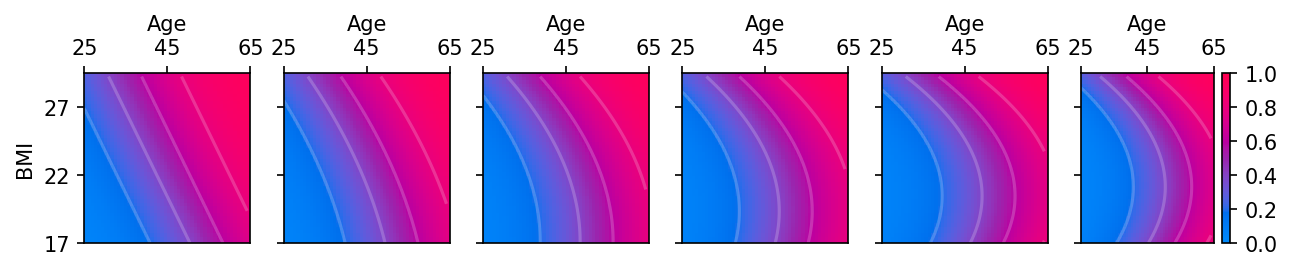

In [14]:
# Main text figure - Plot the true data
fig,axarr = plt.subplots(1,6,dpi=150,figsize=(10,1.5),sharey='all')
for i in range(6):
    p = i*0.2
    xr_pair, primary_xr_pair = zip(*itertools.product(xr,primary_xr))
    mgrid = np.array(gen_y(np.array(primary_xr_pair),np.array(xr_pair),p)).reshape(len(xr),len(primary_xr))
    heatmap = axarr[i].pcolormesh((mgrid),cmap=shap.plots.colors.red_blue,vmin=0,vmax=1)
#     axarr[i].set_title("%.1f Nonlinear"%p)
    axarr[i].xaxis.tick_top()
    axarr[i].xaxis.set_label_position("top")
    axarr[i].set_xlabel("Age")
    axarr[i].set_xticklabels([f'{p*sigma["age"]+mu["age"]:.0f}' for p in primary_xr[[0,20,40]]])
    axarr[i].contour(mgrid,levels=np.linspace(0,1,6),colors="white",alpha=0.2)
axarr[0].set_ylabel("BMI")
axarr[0].set_yticklabels([f'{p*sigma["bmi"]+mu["bmi"]:.0f}' for p in xr[[0,10,20,30,40]]])
fig.colorbar(heatmap,ticks=np.linspace(0,1,6))
plt.subplots_adjust(hspace=0.5)
# plt.savefig("nonlinearity_data.pdf",dpi=300,bbox_inches='tight')

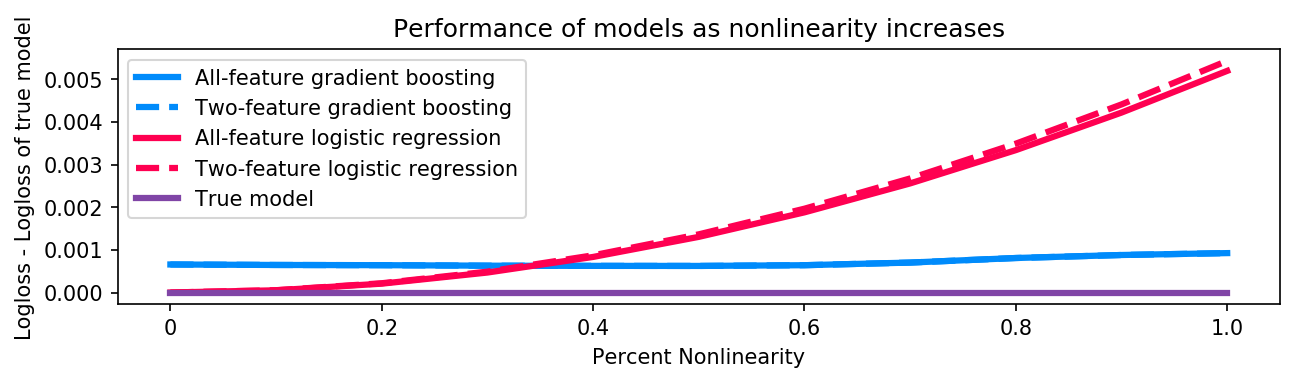

In [15]:
# Main text figure - Performance of models as nonlinearity increases
plt.figure(dpi=150,figsize=(10,2.25))
truth= np.array([-scorefunc(y,y) for r,y in zip(fresults,ys_test)])
xgt= np.array([-scorefunc(y,r['xg_testpreds']) for r,y in zip(fresults,ys_test)])
xgt2= np.array([-scorefunc(y,r['xg_testpreds2']) for r,y in zip(fresults,ys_test)])
lrt= np.array([-scorefunc(y,r['lr_testpreds']) for r,y in zip(fresults,ys_test)])
lrt2= np.array([-scorefunc(y,r['lr_testpreds2']) for r,y in zip(fresults,ys_test)])
plt.plot(xgt-truth,label='All-feature gradient boosting',
         color=shap.plots.colors.blue_rgb,linewidth=3)
plt.plot(xgt2-truth,'--',label='Two-feature gradient boosting',
         color=shap.plots.colors.blue_rgb,linewidth=3)
plt.plot(lrt-truth,label='All-feature logistic regression',
         color=shap.plots.colors.red_rgb,linewidth=3)
plt.plot(lrt2-truth,'--',label='Two-feature logistic regression',
         color=shap.plots.colors.red_rgb,linewidth=3)
plt.plot(truth-truth,label='True model', 
         color=(shap.plots.colors.red_rgb+shap.plots.colors.blue_rgb)/2,linewidth=3)
plt.xlabel("Percent Nonlinearity")
plt.xticks(np.arange(0,11,2),[0,0.2,0.4,0.6,0.8,1.0])
plt.ylabel("Logloss - Logloss of true model")
plt.title("Performance of models as nonlinearity increases")
plt.legend()
# plt.show()
# plt.savefig("nonlinearity_performance_unreg.pdf",dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'Fraction feature weight assigned to irrelevant features')

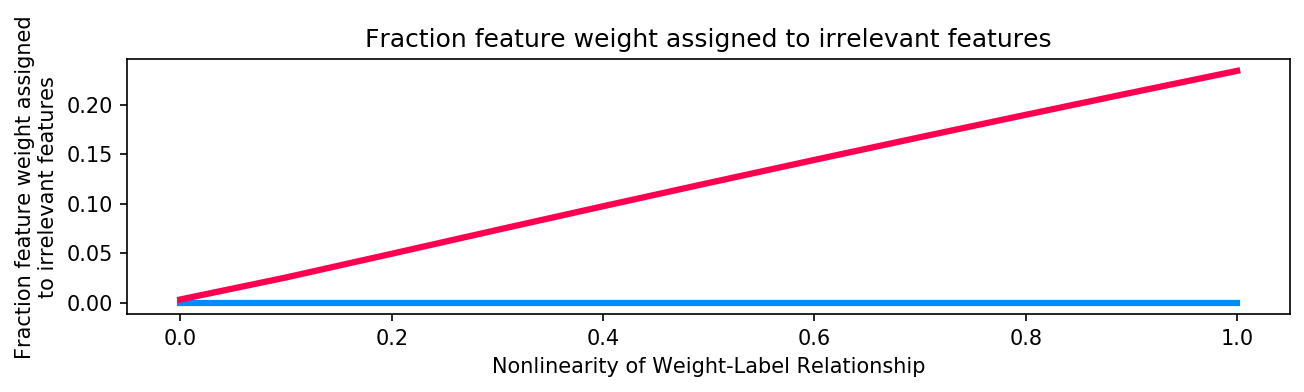

In [16]:
# Main text figure - Fraction feature weight assigned to irrelevant features

plt.figure(dpi=150,figsize=(10,2.25))
plt.plot(prange,frac_imp['xg_'+"other"],label='Gradient Boosting (XGBoost)',color=shap.plots.colors.blue_rgb,linewidth=3)
plt.plot(prange,frac_imp['lr_'+"other"],label='Logistic Regression (StatsModels GLM)',color=shap.plots.colors.red_rgb,linewidth=3)
# plt.plot(prange,frac_imp['true_'+"other"],label='True Contribution',
#          color=(shap.plots.colors.red_rgb+shap.plots.colors.blue_rgb)/2,
#          linewidth=3)
# plt.legend()
plt.xlabel("Nonlinearity of Weight-Label Relationship")
plt.ylabel("Fraction feature weight assigned\nto irrelevant features")
plt.title("Fraction feature weight assigned to irrelevant features")
# plt.savefig("nonlinearity_irrelevant_unreg.pdf",dpi=300,bbox_inches='tight')

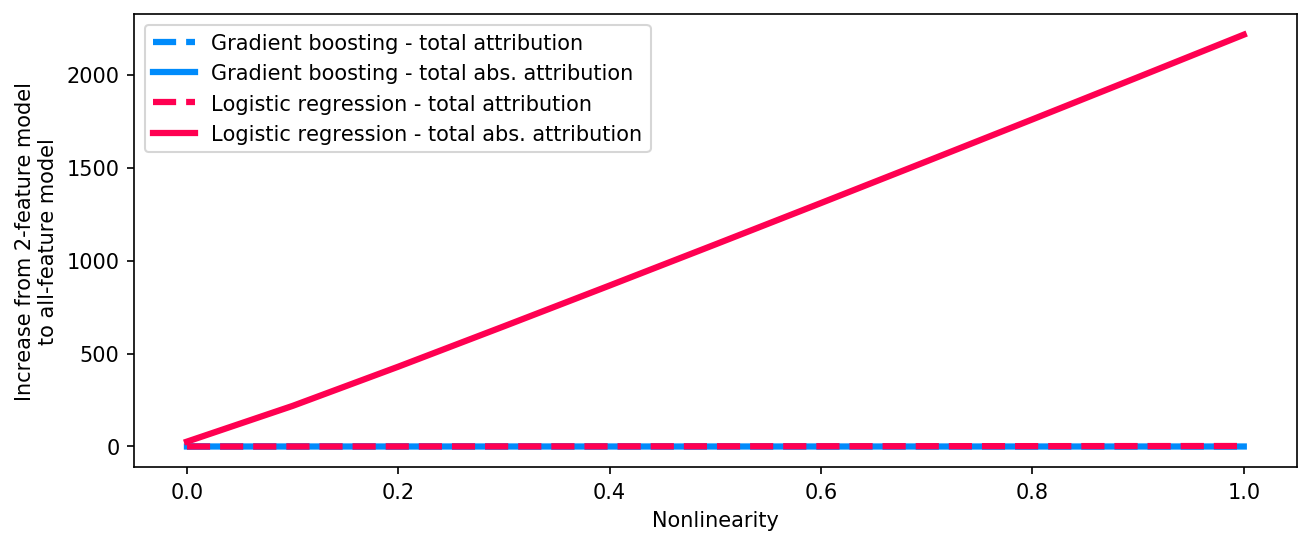

In [17]:
# Supplementary Figure - Cancellation Effects

plt.figure(dpi=150,figsize=(10,4))

total_lr = np.array([np.sum(np.abs(t.values)) for t in full_tshaps['lr']])
total_lr2 = np.array([np.sum(np.abs(t.values)) for t in full_tshaps['lr2']])

margin_lr = np.array([np.sum(t.values) for t in full_tshaps['lr']])
margin_lr2 = np.array([np.sum(t.values) for t in full_tshaps['lr2']])

total_xg = np.array([np.sum(np.abs(t)) for t in full_tshaps['xg']])
total_xg2 = np.array([np.sum(np.abs(t)) for t in full_tshaps['xg2']])

margin_xg = np.array([np.sum(t) for t in full_tshaps['xg']])
margin_xg2 = np.array([np.sum(t) for t in full_tshaps['xg2']])

plt.plot(prange,margin_xg-margin_xg2,label='Gradient boosting - total attribution',color=shap.plots.colors.blue_rgb,linewidth=3,linestyle='--')
plt.plot(prange,total_xg-total_xg2,label='Gradient boosting - total abs. attribution',color=shap.plots.colors.blue_rgb,linewidth=3)

plt.plot(prange,margin_lr-margin_lr2,label='Logistic regression - total attribution',color=shap.plots.colors.red_rgb,linewidth=3,linestyle='--')
plt.plot(prange,total_lr-total_lr2,label='Logistic regression - total abs. attribution',color=shap.plots.colors.red_rgb,linewidth=3)
plt.xlabel("Nonlinearity")
plt.ylabel("Increase from 2-feature model\nto all-feature model")
plt.legend()
# plt.savefig("nonlinearity_supp_both_unreg.pdf")